In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Part 1

In [28]:
file_path = "../scripts/evaluation/karel/eval8_harvester_sweep50_noFE.pkl"
with open(file_path, 'rb') as f:
    my_dict = pickle.load(f)

In [60]:
file_path = "../scripts/evaluation/karel/eval8_harvester_sweep43_FE100_SF50.pkl"
with open(file_path, 'rb') as f:
    my_dict = pickle.load(f)

In [23]:
my_dict

[(0.8222222222222226,
  {'params': {'lr': 0.001,
    'l1': 0.0005,
    'ent_coef': 0.01,
    'clip_coef': 0.01,
    'hidden_size': 64,
    'game_size': '10x10',
    'ppo_type': 'original'},
   'seeds': defaultdict(dict,
               {3: {0: (0.777777777777778, 100),
                 1: (0.777777777777778, 100),
                 2: (0.777777777777778, 100),
                 3: (0.8888888888888892, 100),
                 4: (0.777777777777778, 100),
                 5: (0.777777777777778, 100),
                 6: (0.777777777777778, 100),
                 7: (0.8888888888888892, 100),
                 8: (0.8888888888888892, 100),
                 9: (0.8888888888888892, 100)},
                1: {0: (0.777777777777778, 100),
                 1: (0.777777777777778, 100),
                 2: (0.777777777777778, 100),
                 3: (0.8888888888888892, 100),
                 4: (0.777777777777778, 100),
                 5: (0.777777777777778, 100),
                 6: (0.777777777

In [61]:
def plot_hyperparam_effect(sorted_groups, hyperparam='l1'):
    # Extract data from your dictionary structure
    data = []
    for avg_reward, group in sorted_groups:
        params = group['params']
        data.append({
            'Hyperparameter': params[hyperparam],
            'Average Reward': avg_reward,
            'hidden_size': params['hidden_size'],
            'lr': params['lr'],
            'ent_coef': params['ent_coef'],
            'clip_coef': params['clip_coef'],
        })
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(13, 6))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(121)
    
    # Special handling for L1=0
    if hyperparam == 'l1':
        sns.regplot(x='Hyperparameter', y='Average Reward', data=df,
                    scatter_kws={'alpha':0.7, 's':60, 'color':'steelblue'}, 
                    line_kws={'color':'darkred'}, ax=ax1)
        plt.xlabel('L1 Lambda')
    else:
        # Handle possible division by zero for non-L1 params
        positive_vals = df[df['Hyperparameter'] > 0]['Hyperparameter']
        if not positive_vals.empty:
            value_ratio = df['Hyperparameter'].max() / positive_vals.min()
            if value_ratio > 100:
                plt.xscale('log')
        
        sns.regplot(x='Hyperparameter', y='Average Reward', data=df,
                    scatter_kws={'alpha':0.7, 's':60, 'color':'steelblue'}, 
                    line_kws={'color':'darkred'}, ax=ax1)
    
    plt.title(f'{hyperparam} vs Average Reward')
    plt.grid(True, alpha=0.3)
    
    # Box plot with custom bins
    ax2 = plt.subplot(122)
    
    if hyperparam == 'l1':
        bins = pd.Categorical(df['Hyperparameter'].round(6), 
                             categories=sorted(df['Hyperparameter'].unique()))
    else:
        if df['Hyperparameter'].nunique() > 10:
            bins = pd.qcut(df['Hyperparameter'], q=6, duplicates='drop')
        else:
            bins = df['Hyperparameter']
    
    # Fixed boxplot with hue parameter
    sns.boxplot(x=bins, y='Average Reward', data=df, 
                hue=bins, palette='viridis', ax=ax2, legend=False)
    plt.title(f'Average Reward Distribution by {hyperparam}')
    plt.xticks(rotation=45 if hyperparam == 'l1' else 0)
    plt.xlabel(hyperparam)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

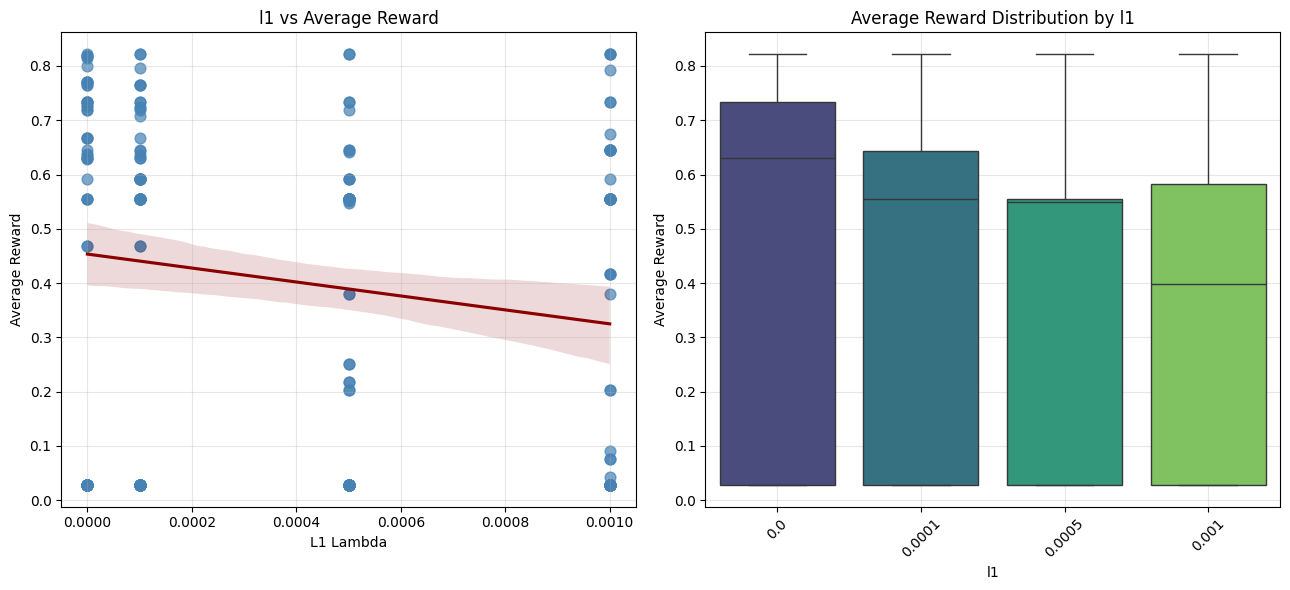

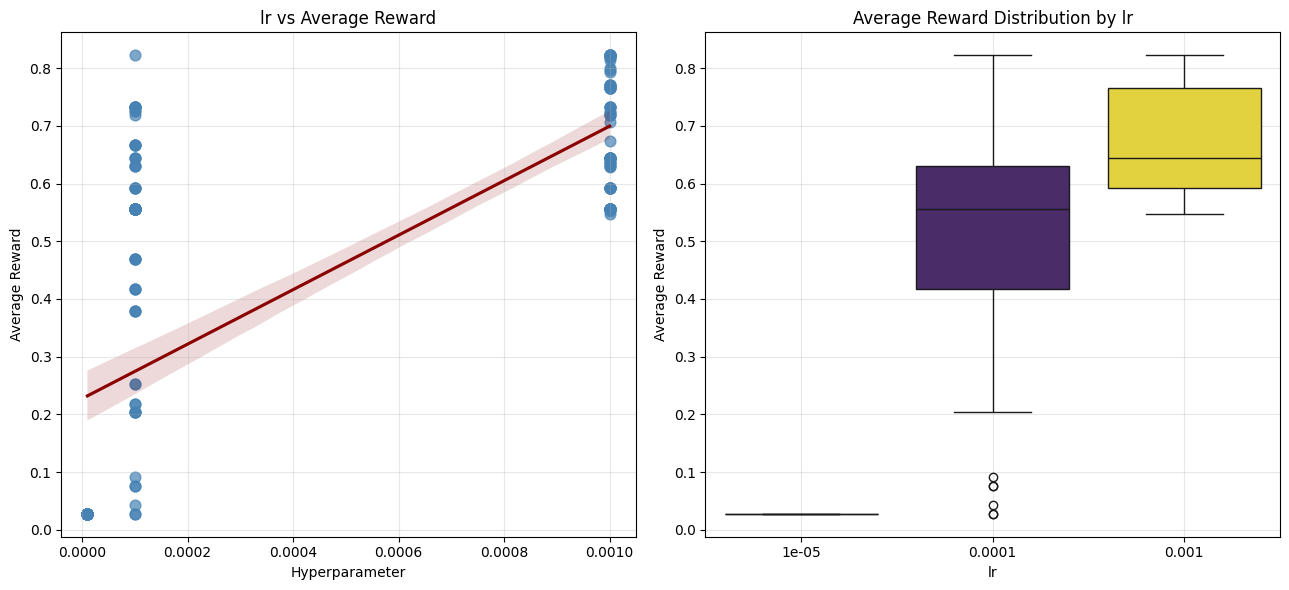

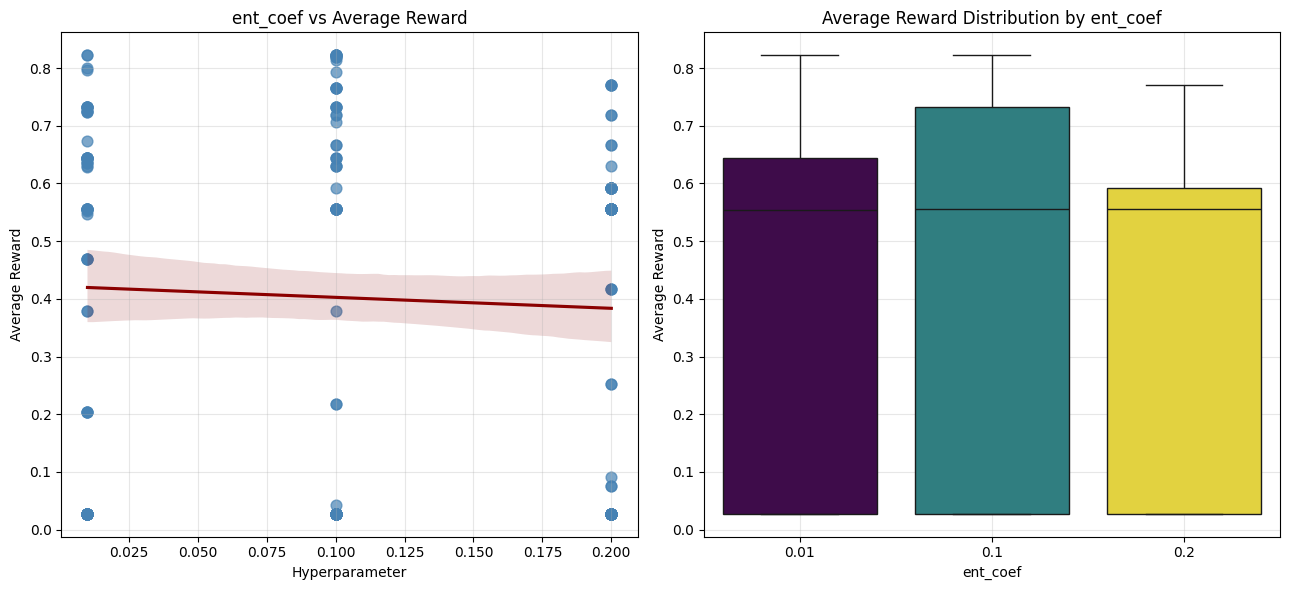

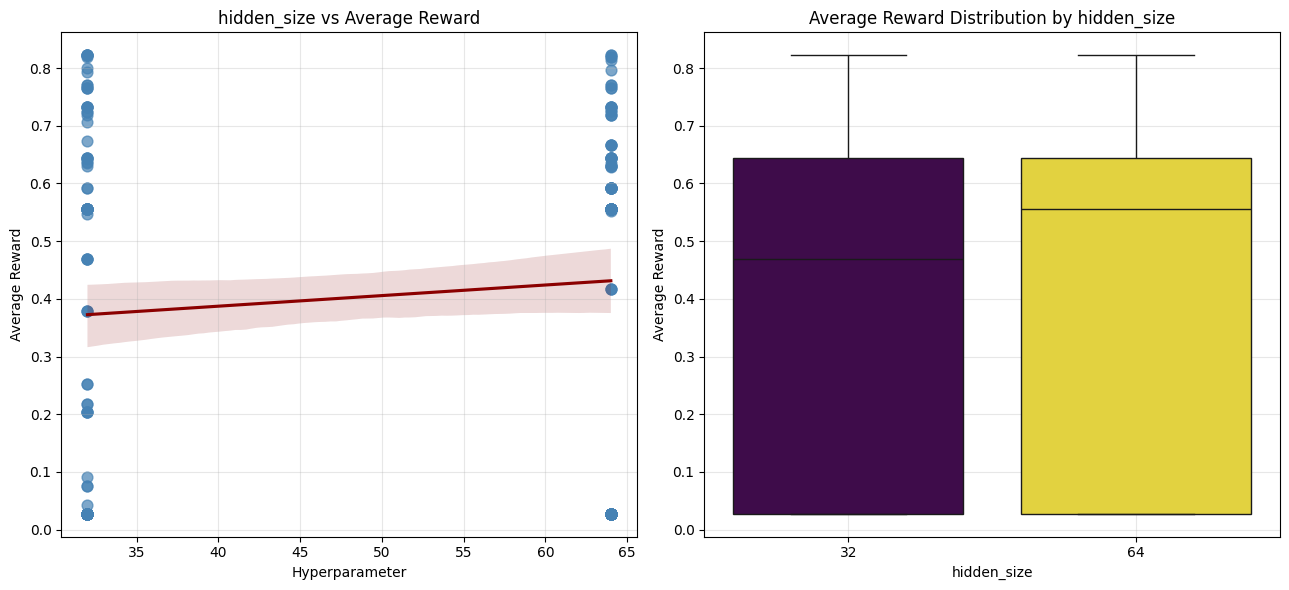

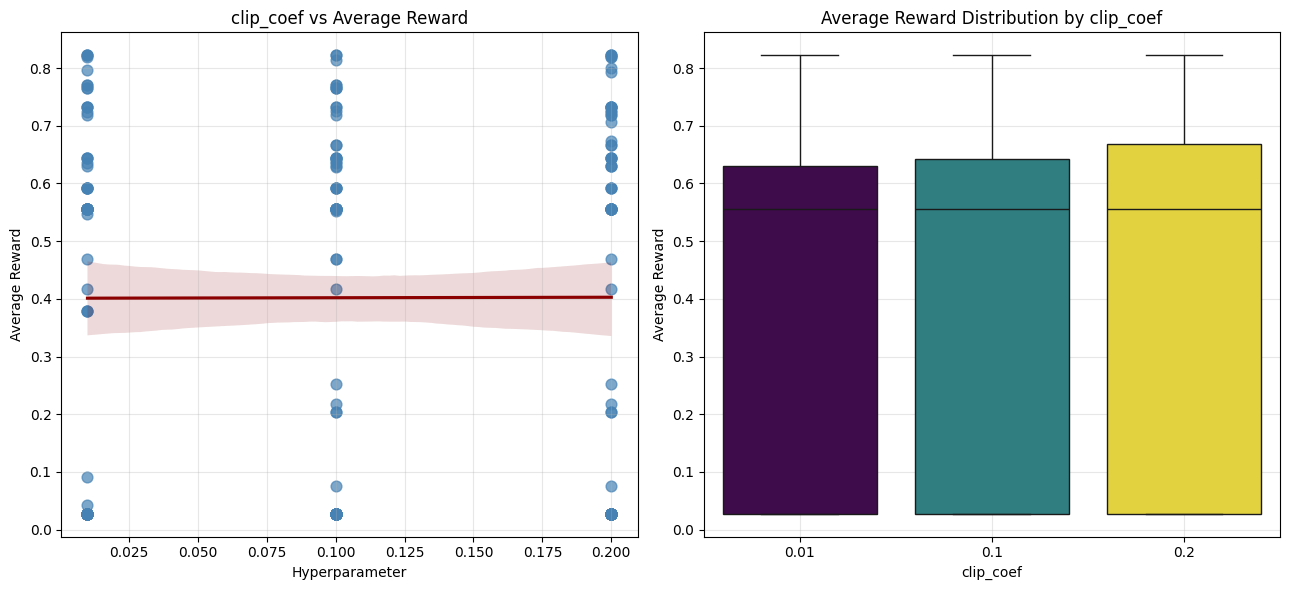

In [62]:
plot_hyperparam_effect(my_dict, hyperparam='l1')
plot_hyperparam_effect(my_dict, hyperparam='lr')
plot_hyperparam_effect(my_dict, hyperparam='ent_coef')
plot_hyperparam_effect(my_dict, hyperparam='hidden_size')
plot_hyperparam_effect(my_dict, hyperparam='clip_coef')

In [49]:
def plot_dual_hyperparam_effect(sorted_groups, hyperparam1='l1', hyperparam2='lr'):
    # Extract and prepare data
    data = []
    for avg_reward, group in sorted_groups:
        params = group['params']
        data.append({
            hyperparam1: params[hyperparam1],
            hyperparam2: params[hyperparam2],
            'Average Reward': avg_reward,
            'Count': len(group['seeds'])  # Number of model seeds
        })
    
    df = pd.DataFrame(data)
    
    # Aggregate results for each hyperparameter pair
    df_grouped = df.groupby([hyperparam1, hyperparam2]).agg({
        'Average Reward': 'mean',
        'Count': 'sum'
    }).reset_index()

    # Create categorical ordering for L1 if needed
    if hyperparam1 == 'l1':
        l1_values = sorted(df_grouped[hyperparam1].unique())
        df_grouped[hyperparam1] = pd.Categorical(df_grouped[hyperparam1], 
                                                categories=l1_values,
                                                ordered=True)

    plt.figure(figsize=(12, 7))
    
    # Create bubble plot
    scatter = plt.scatter(
        x=df_grouped[hyperparam1],
        y=df_grouped[hyperparam2],
        s=df_grouped['Count']*40,  # Scale bubble size by sample count
        c=df_grouped['Average Reward'],
        cmap='viridis',
        alpha=0.8,
        edgecolors='w',
        linewidth=0.5
    )

    # Formatting
    plt.title(f'Interaction between {hyperparam1} and {hyperparam2}', pad=20)
    plt.xlabel(hyperparam1.capitalize())
    plt.ylabel(hyperparam2.capitalize())
    
    # Use log scales if appropriate
    if hyperparam2 == 'lr':
        plt.yscale('log')
    
    if hyperparam1 == 'l1':
        plt.xticks(ticks=l1_values, labels=l1_values)
    elif hyperparam1 == 'lr':
        plt.xscale('log')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Reward')
    
    # Add legend for bubble sizes
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=5)
    legend2 = plt.legend(
        handles, labels,
        loc="upper right" if hyperparam1 == 'l1' else "best",
        title="Sample Count",
        bbox_to_anchor=(1.25, 1) if hyperparam1 == 'l1' else None
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

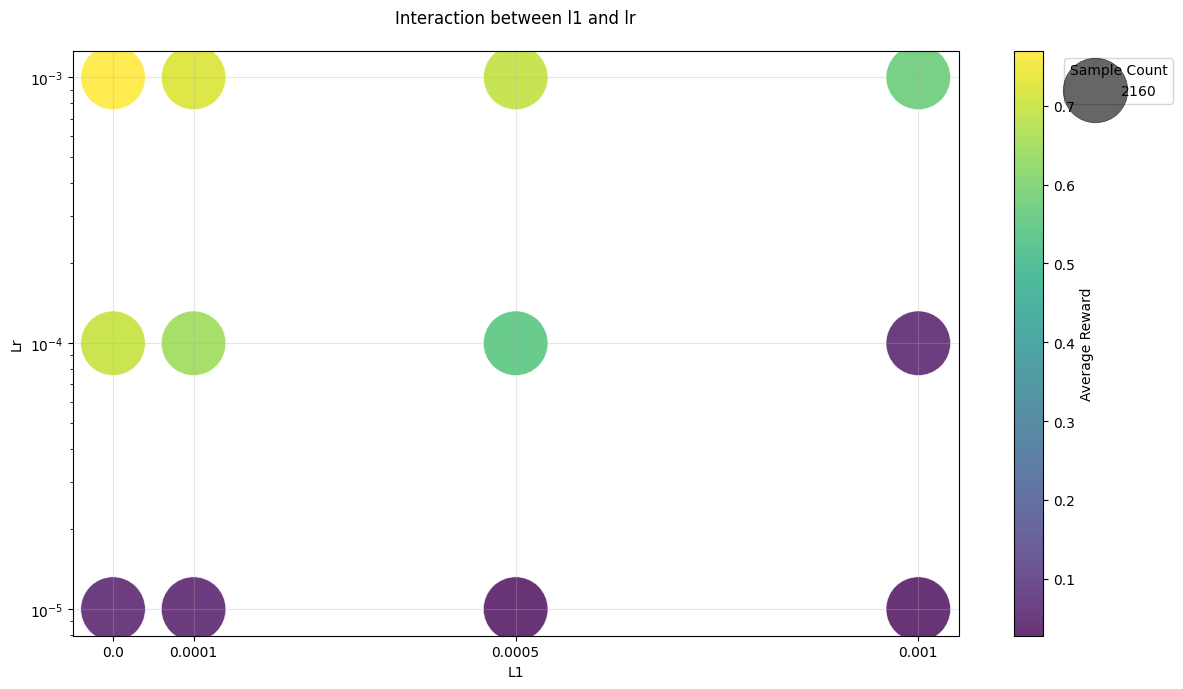

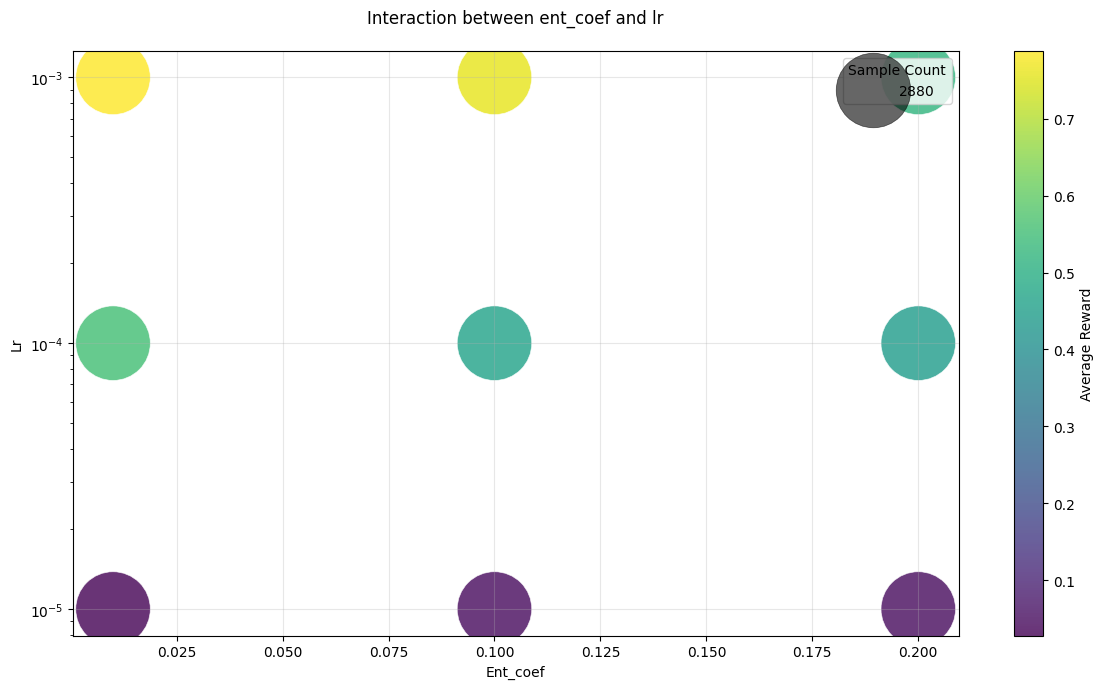

In [50]:
plot_dual_hyperparam_effect(my_dict, hyperparam1='l1', hyperparam2='lr')

plot_dual_hyperparam_effect(my_dict, hyperparam1='ent_coef', hyperparam2='lr')

In [63]:

def plot_3d_hyperparam_effect(sorted_groups, hyperparam1='l1', hyperparam2='lr'):
    # Extract and prepare data
    data = []
    for avg_reward, group in sorted_groups:
        params = group['params']
        data.append({
            hyperparam1: params[hyperparam1],
            hyperparam2: params[hyperparam2],
            'Average Reward': avg_reward
        })
    
    df = pd.DataFrame(data)
    
    # Create grid for surface plot (handle missing combinations)
    df_grouped = df.pivot_table(index=hyperparam1, 
                               columns=hyperparam2, 
                               values='Average Reward',
                               aggfunc='mean')
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare grid coordinates
    X = df_grouped.columns.values  # hyperparam2 values
    Y = df_grouped.index.values    # hyperparam1 values
    X, Y = np.meshgrid(X, Y)
    Z = df_grouped.values
    
    # Create surface plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', 
                          edgecolor='k', alpha=0.8,
                          rstride=1, cstride=1)
    
    # Formatting
    ax.set_xlabel(hyperparam2.capitalize(), labelpad=15)
    ax.set_ylabel(hyperparam1.capitalize(), labelpad=15)
    ax.set_zlabel('Average Reward', labelpad=15)
    
    # Improved formatting for learning rates
    if hyperparam2 == 'lr':
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0e}'))
    if hyperparam1 == 'lr':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0e}'))
    
    # Add color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Average Reward')
    
    # Adjust view
    ax.view_init(elev=25, azim=-45)
    plt.title(f'3D Interaction: {hyperparam1} vs {hyperparam2}', y=1.0, pad=30)
    
    plt.tight_layout()
    plt.show()

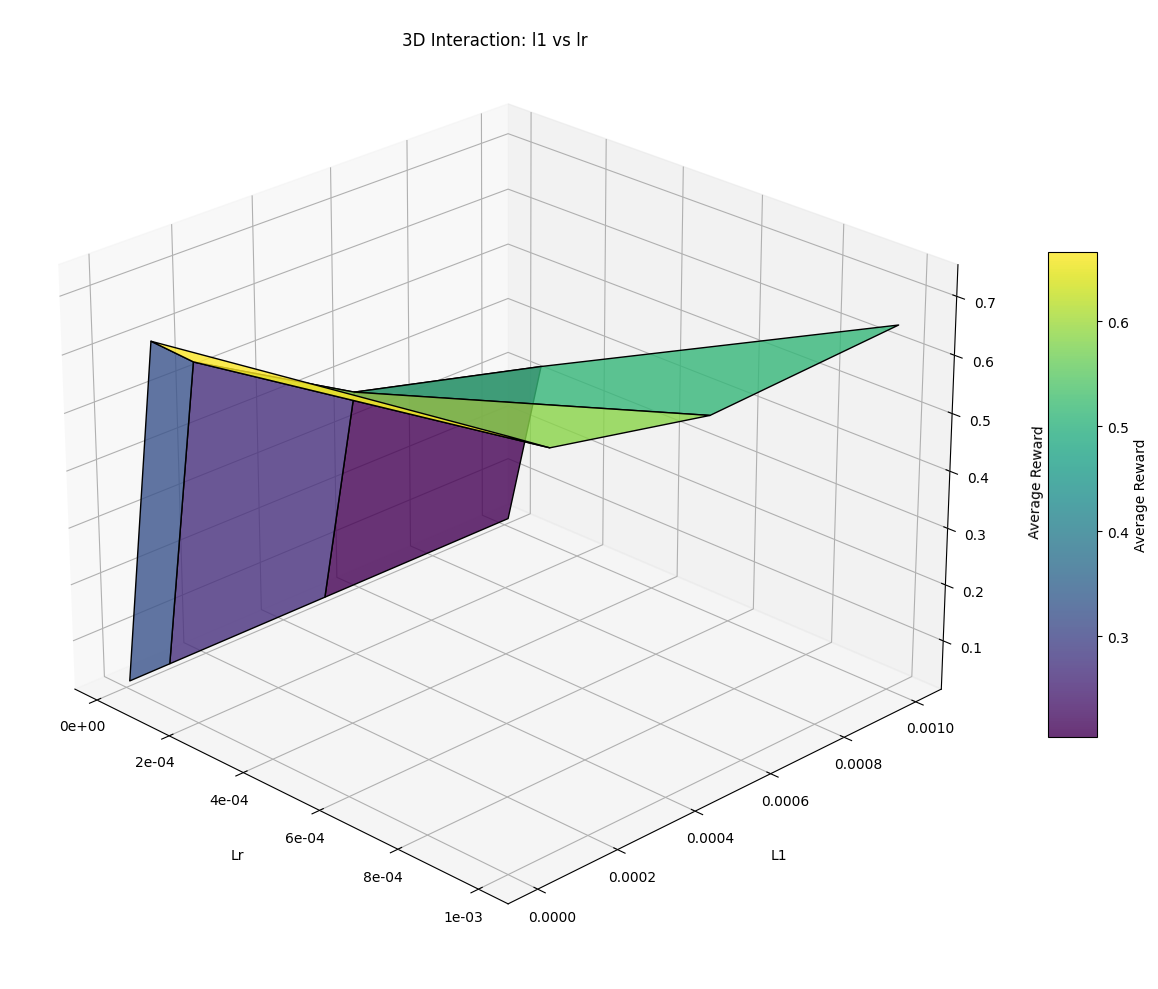

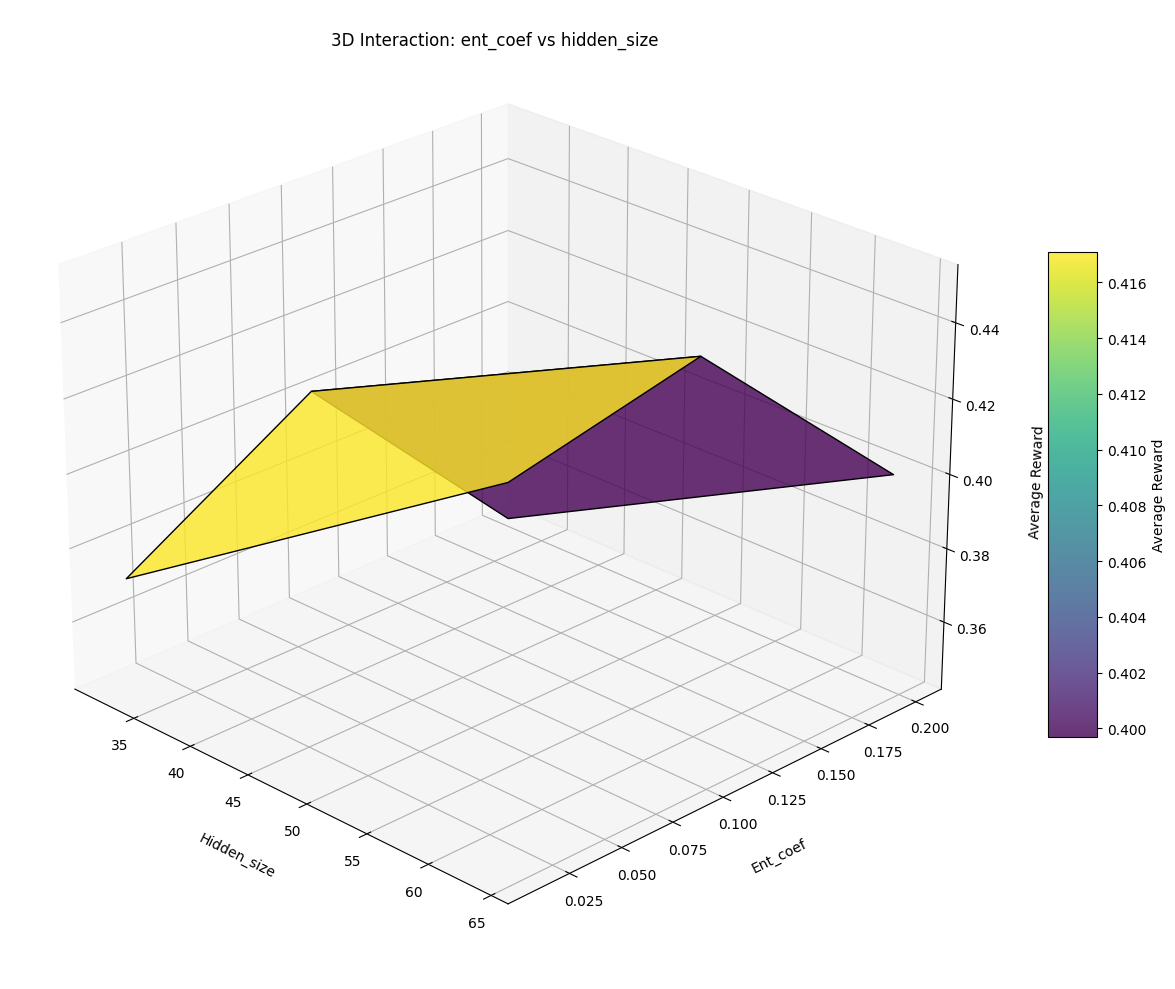

In [64]:
plot_3d_hyperparam_effect(my_dict, hyperparam1='l1', hyperparam2='lr')

plot_3d_hyperparam_effect(my_dict, hyperparam1='ent_coef', hyperparam2='hidden_size')

In [65]:
import plotly.graph_objects as go

def plot_interactive_3d(sorted_groups, hyperparam1='l1', hyperparam2='lr'):
    # Extract and prepare data
    data = []
    for avg_reward, group in sorted_groups:
        params = group['params']
        data.append({
            hyperparam1: params[hyperparam1],
            hyperparam2: params[hyperparam2],
            'Average Reward': avg_reward
        })
    
    df = pd.DataFrame(data)
    
    # Create grid for surface plot
    df_grouped = df.pivot_table(index=hyperparam1, 
                               columns=hyperparam2, 
                               values='Average Reward',
                               aggfunc='mean')
    
    # Prepare grid coordinates
    x = df_grouped.columns.values  # hyperparam2 values
    y = df_grouped.index.values    # hyperparam1 values
    X, Y = np.meshgrid(x, y)
    Z = df_grouped.values
    
    # Create interactive surface plot
    fig = go.Figure(data=[go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        hovertemplate=
            f'{hyperparam2}: %{{x}}<br>' +
            f'{hyperparam1}: %{{y}}<br>' +
            'Average Reward: %{z}<extra></extra>'
    )])
    
    # Format axes
    axis_template = dict(
        title = '',
        showgrid=True,
        gridcolor='lightgray',
        backgroundcolor='rgb(230, 230, 230)'
    )
    
    fig.update_layout(
        title=f'3D Interaction: {hyperparam1} vs {hyperparam2}',
        scene=dict(
            xaxis=axis_template | dict(title=hyperparam2.capitalize()),
            yaxis=axis_template | dict(title=hyperparam1.capitalize()),
            zaxis=axis_template | dict(title='Average Reward'),
        ),
        margin=dict(l=65, r=50, b=65, t=90),
        width=1000,
        height=800
    )
    
    # Handle log scales
    if hyperparam2 == 'lr':
        fig.update_layout(scene_xaxis_type='log')
    if hyperparam1 == 'lr':
        fig.update_layout(scene_yaxis_type='log')
    
    # Add color bar
    fig.update_layout(coloraxis_colorbar=dict(
        title='Average Reward',
        title_side='right'
    ))
    
    fig.show()

In [66]:
plot_interactive_3d(my_dict, hyperparam1='l1', hyperparam2='lr')

## Part 2

In [56]:
files = ["eval12_stair_sweep34_noFE.pkl", "eval8_maze_sweep28_noFE.pkl", "eval12_fourcorner_sweep40_noFE.pkl", "eval12_top_sweep50_noFE.pkl" ]
my_dicts = []
base_path = "../scripts/evaluation/karel/paper/"
for file in files:
    file_path = base_path + file
    with open(file_path, 'rb') as f:
        my_dict = pickle.load(f)
        my_dicts.append(my_dict)    


In [57]:
# Extract the mutual hyperparameters that resulted in avr reward == 1
from operator import itemgetter
keys_to_get = ["hidden_size", "lr", "ent_coef", "clip_coef", "l1"]
getter = itemgetter(*keys_to_get)

good_sets = []
for dict in my_dicts:
    good_sets_task = [getter(info["params"])  for avg_reward, info in dict if avg_reward == 1.]
    good_sets.append(good_sets_task)

In [58]:
# Find the intersection (overlapping elements) among all good_sets from each task
common_elements = set(good_sets[0])
for gs in good_sets[1:]:
    common_elements &= set(gs)

In [59]:
len(common_elements), common_elements

(8,
 {(32, 0.001, 0.01, 0.01, 0.0),
  (32, 0.001, 0.1, 0.01, 0.0),
  (32, 0.001, 0.1, 0.1, 0.0),
  (32, 0.001, 0.1, 0.2, 0.0),
  (64, 0.001, 0.01, 0.01, 0.0),
  (64, 0.001, 0.1, 0.01, 0.0),
  (64, 0.001, 0.1, 0.1, 0.0),
  (64, 0.001, 0.1, 0.2, 0.0)})

## Part 3

In [83]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Define the desired hyperparameters
desired_hyperparams = {
    (32, 0.001, 0.01, 0.01, 0.0),
    (32, 0.001, 0.1, 0.01, 0.0),
    (32, 0.001, 0.1, 0.1, 0.0),
    (32, 0.001, 0.1, 0.2, 0.0),
    (64, 0.001, 0.01, 0.01, 0.0),
    (64, 0.001, 0.1, 0.01, 0.0),
    (64, 0.001, 0.1, 0.1, 0.0),
    (64, 0.001, 0.1, 0.2, 0.0)
}

def parse_hyperparams(dir_name):
    # Match parameters with seed and required pattern
    h_match = re.search(r'_H(\d+)$', dir_name)
    lr_match = re.search(r'_LR([\d\.]+)', dir_name)
    clip_match = re.search(r'_CLIP([\d\.]+)', dir_name)
    ent_match = re.search(r'_ENT([\d\.]+)', dir_name)
    l1_match = re.search(r'_L1([\d\.]+)', dir_name)
    seed_match = re.search(r'_SD(\d+)', dir_name)
    
    if not all([h_match, lr_match, clip_match, ent_match, l1_match, seed_match]):
        return None
    
    H = int(h_match.group(1))
    LR = float(lr_match.group(1))
    CLIP = float(clip_match.group(1))
    ENT = float(ent_match.group(1))
    L1 = float(l1_match.group(1))
    seed = int(seed_match.group(1))
    
    return (H, LR, ENT, CLIP, L1, seed)

In [ ]:
# Collect matching directories
base_dir = "../../outputs/karel_sweeps"
matching_dirs = {}

for dir_name in os.listdir(base_dir):
    dir_path = os.path.join(base_dir, dir_name)
    if not os.path.isdir(dir_path):
        continue
    
    # Check for required pattern in directory name
    if "fourcorner_sweep40_noFE" not in dir_name:
        continue
    
    hp_data = parse_hyperparams(dir_name)
    if not hp_data:
        continue
    print(f"Parsed HP: {hp_data}")
    
    # Extract hyperparameters without seed
    hp = hp_data[:5]
    seed = hp_data[5]
    
    if hp in desired_hyperparams:
        if hp not in matching_dirs:
            matching_dirs[hp] = []
        matching_dirs[hp].append(dir_path)

# Verify we have 3 seeds per configuration
for hp, dirs in matching_dirs.items():
    if len(dirs) != 3:
        print(f"Warning: Configuration {hp} has {len(dirs)} seeds (expected 3)")
        print(f"Found directories: {dirs}")

In [107]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

test_dir = "../../outputs/karel_sweeps/Karel_four_corner__2000000__2__1739317152_fourcorner_sweep40_noFE_SD2_LR0.001_CLIP0.01_ENT0.01_L10.0_H64/events.out.tfevents.1739317152.cdr2045.int.cedar.computecanada.ca.1682198.0"
# test_dir = "../../outputs/tensorboard/runs/Karel_four_corner__2000000__1__1747159937_Karel_fourcorner_30seeds_noFE"
event_acc = EventAccumulator(test_dir)
event_acc.Reload()
print(event_acc.Tags())

{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [98]:
# Load scalar data from each directory
scalar_data = {}

for hp, dirs in matching_dirs.items():
    scalar_data[hp] = {}
    print(f"\nProcessing hyperparams: {hp}")
    
    for run_idx, run_dir in enumerate(dirs):
        print(f"  Loading run {run_idx+1}: {os.path.basename(run_dir)}")
        
        # Verify event file exists
        event_files = [f for f in os.listdir(run_dir) if f.startswith("events.out.tfevents")]
        if not event_files:
            print(f"    !! No event files found in {run_dir}")
            continue
            
        try:
            event_acc = EventAccumulator(run_dir)
            event_acc.Reload()
            
            # Verify tags
            tags = event_acc.Tags().get('scalars', [])
            print(f"    Found {len(tags)} scalars: {tags}")
            
            for tag in tags:
                if tag not in scalar_data[hp]:
                    scalar_data[hp][tag] = []
                    
                events = event_acc.Scalars(tag)
                df = pd.DataFrame([(e.step, e.value) for e in events], 
                                columns=['step', 'value']).set_index('step')
                scalar_data[hp][tag].append(df)
                print(f"    Loaded {len(events)} entries for {tag}")
                
        except Exception as e:
            print(f"    !! Error loading {run_dir}: {str(e)}")
            continue


Processing hyperparams: (64, 0.001, 0.01, 0.01, 0.0)
  Loading run 1: Karel_four_corner__2000000__2__1739317152_fourcorner_sweep40_noFE_SD2_LR0.001_CLIP0.01_ENT0.01_L10.0_H64
    Found 0 scalars: []
  Loading run 2: Karel_four_corner__2000000__1__1739309722_fourcorner_sweep40_noFE_SD1_LR0.001_CLIP0.01_ENT0.01_L10.0_H64
    Found 0 scalars: []
  Loading run 3: Karel_four_corner__2000000__3__1739321564_fourcorner_sweep40_noFE_SD3_LR0.001_CLIP0.01_ENT0.01_L10.0_H64
    Found 0 scalars: []

Processing hyperparams: (32, 0.001, 0.1, 0.1, 0.0)
  Loading run 1: Karel_four_corner__2000000__2__1739317910_fourcorner_sweep40_noFE_SD2_LR0.001_CLIP0.1_ENT0.1_L10.0_H32
    Found 0 scalars: []
  Loading run 2: Karel_four_corner__2000000__1__1739309960_fourcorner_sweep40_noFE_SD1_LR0.001_CLIP0.1_ENT0.1_L10.0_H32
    Found 0 scalars: []
  Loading run 3: Karel_four_corner__2000000__3__1739322257_fourcorner_sweep40_noFE_SD3_LR0.001_CLIP0.1_ENT0.1_L10.0_H32
    Found 0 scalars: []

Processing hyperparams:

In [99]:
scalar_data

{(64, 0.001, 0.01, 0.01, 0.0): {},
 (32, 0.001, 0.1, 0.1, 0.0): {},
 (64, 0.001, 0.1, 0.01, 0.0): {},
 (32, 0.001, 0.01, 0.01, 0.0): {},
 (32, 0.001, 0.1, 0.01, 0.0): {},
 (64, 0.001, 0.1, 0.2, 0.0): {},
 (64, 0.001, 0.1, 0.1, 0.0): {},
 (32, 0.001, 0.1, 0.2, 0.0): {}}

In [97]:
matching_dirs[(64, 0.001, 0.01, 0.01, 0.0)]

['../../outputs/karel_sweeps/Karel_four_corner__2000000__2__1739317152_fourcorner_sweep40_noFE_SD2_LR0.001_CLIP0.01_ENT0.01_L10.0_H64',
 '../../outputs/karel_sweeps/Karel_four_corner__2000000__1__1739309722_fourcorner_sweep40_noFE_SD1_LR0.001_CLIP0.01_ENT0.01_L10.0_H64',
 '../../outputs/karel_sweeps/Karel_four_corner__2000000__3__1739321564_fourcorner_sweep40_noFE_SD3_LR0.001_CLIP0.01_ENT0.01_L10.0_H64']

In [89]:
len(matching_dirs)

8